In [1]:
import numpy as np
from scipy.interpolate import CubicSpline, interp1d
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm, trange
import json
from scipy.optimize import minimize

csd_sse_df = pd.read_csv('../data/cleaned_csd76_sse.csv').set_index('Unnamed: 0')

csd_hfx_df = pd.read_csv('../data/CSD76targets.csv').set_index('Unnamed: 0').clip(lower=0, upper=100)

csd_76 = pd.read_csv('../data/CSD-76.csv').set_index('name')

vss_sse_df = pd.read_csv('../data/cleaned_vss452_sse.csv').set_index('Unnamed: 0')
names = {}
for name in vss_sse_df.index:
    elems = name.split('/')
    names[name] =elems[-1]
vss_sse_df = vss_sse_df.rename(index=names)

vss_hfx_df = pd.read_csv('../data/VSS452targets.csv').set_index('Unnamed: 0')
names = {}
for name in vss_hfx_df.index:
    elems = name.split('/')
    names[name] =elems[-1]
vss_hfx_df = vss_hfx_df.rename(index=names)
vss_hfx_df = vss_hfx_df.clip(lower=0, upper=100)

vss_452 = pd.read_csv('../data/VSS-452.csv').set_index('name')

In [2]:
def default_AEs(pred_df, dataset):

    def pred_energy(structure, functional, dataset):
        if dataset == 'csd':
            df = csd_76
            sse_df = csd_sse_df
            hfx_df = csd_hfx_df
        elif dataset == 'vss':
            df = vss_452
            sse_df = vss_sse_df
            hfx_df = vss_hfx_df
        else:
            raise ValueError("Specify a valid dataset!")
        pred_hfx = 25
        
        sses = []
        all_increments = np.arange(0, 101, 5)
        increments = []
        for increment in all_increments:
            sse = sse_df.loc[structure][functional + '_hfx_' + str(increment)]
            if not np.isnan(sse):
                increments.append(increment)
                sses.append(sse)
        if len(increments) < 5:
            #print('Not enough converged values!')
            return

        line = interp1d(increments, sses, kind='linear', fill_value='extrapolate')
        return line(pred_hfx)

    if dataset == 'csd':
        df = csd_76
        sse_df = csd_sse_df
        hfx_df = csd_hfx_df
    elif dataset == 'vss':
        df = vss_452
        sse_df = vss_sse_df
        hfx_df = vss_hfx_df

    pbe_errors = []
    scan_errors = []

    for struct in tqdm(pred_df.index.to_list()):
        if dataset == 'csd':
            reference = csd_76.loc[struct]['dlpno-CCSD_T.vertsse']
        elif dataset == 'vss':
            reference = vss_452.loc[struct]['dlpno-CCSD_T.vertsse']
        else:
            raise ValueError('Provide a proper reference')
        pbe_energy = pred_energy(struct, 'pbe', dataset)
        if pbe_energy is not None:
            pbe_errors.append(reference - pbe_energy)
        scan_energy = pred_energy(struct, 'scan', dataset)
        if scan_energy is not None:
            scan_errors.append(reference-scan_energy)

    return np.abs(np.array(pbe_errors)), np.abs(np.array(scan_errors))

def transferred_AEs(pred_df, dataset):

    def pred_energy(structure, functional, dataset):
        if dataset == 'csd':
            df = csd_76
            sse_df = csd_sse_df
            hfx_df = csd_hfx_df
            if functional == 'pbe':
                pred_hfx = 35.12
            else:
                pred_hfx = 37.21
        elif dataset == 'vss':
            df = vss_452
            sse_df = vss_sse_df
            hfx_df = vss_hfx_df
            if functional == 'pbe':
                pred_hfx = 31.26
            else:
                pred_hfx = 33.07
        else:
            raise ValueError("Specify a valid dataset!")
        
        sses = []
        all_increments = np.arange(0, 101, 5)
        increments = []
        for increment in all_increments:
            sse = sse_df.loc[structure][functional + '_hfx_' + str(increment)]
            if not np.isnan(sse):
                increments.append(increment)
                sses.append(sse)
        if len(increments) < 5:
            #print('Not enough converged values!')
            return

        line = interp1d(increments, sses, kind='linear', fill_value='extrapolate')
        return line(pred_hfx)

    if dataset == 'csd':
        df = csd_76
        sse_df = csd_sse_df
        hfx_df = csd_hfx_df
    elif dataset == 'vss':
        df = vss_452
        sse_df = vss_sse_df
        hfx_df = vss_hfx_df

    pbe_errors = []
    scan_errors = []

    for struct in tqdm(pred_df.index.to_list()):
        if dataset == 'csd':
            reference = csd_76.loc[struct]['dlpno-CCSD_T.vertsse']
        elif dataset == 'vss':
            reference = vss_452.loc[struct]['dlpno-CCSD_T.vertsse']
        else:
            raise ValueError('Provide a proper reference')
        pbe_energy = pred_energy(struct, 'pbe', dataset)
        if pbe_energy is not None:
            pbe_errors.append(reference - pbe_energy)
        scan_energy = pred_energy(struct, 'scan', dataset)
        if scan_energy is not None:
            scan_errors.append(reference-scan_energy)

    return np.abs(np.array(pbe_errors)), np.abs(np.array(scan_errors))

def optimal_AEs(pred_df, dataset):

    def pred_energy(structure, functional, dataset):
        if dataset == 'csd':
            df = csd_76
            sse_df = csd_sse_df
            hfx_df = csd_hfx_df
        elif dataset == 'vss':
            df = vss_452
            sse_df = vss_sse_df
            hfx_df = vss_hfx_df
        else:
            raise ValueError("Specify a valid dataset!")
        pred_hfx = hfx_df.loc[structure]['hfx_' + functional]
        
        sses = []
        all_increments = np.arange(0, 101, 5)
        increments = []
        for increment in all_increments:
            sse = sse_df.loc[structure][functional + '_hfx_' + str(increment)]
            if not np.isnan(sse):
                increments.append(increment)
                sses.append(sse)
        if len(increments) < 5:
            #print('Not enough converged values!')
            return

        line = interp1d(increments, sses, kind='linear', fill_value='extrapolate')
        return line(pred_hfx)

    if dataset == 'csd':
        df = csd_76
        sse_df = csd_sse_df
        hfx_df = csd_hfx_df
    elif dataset == 'vss':
        df = vss_452
        sse_df = vss_sse_df
        hfx_df = vss_hfx_df

    pbe_errors = []
    scan_errors = []

    for struct in tqdm(pred_df.index.to_list()):
        if dataset == 'csd':
            reference = csd_76.loc[struct]['dlpno-CCSD_T.vertsse']
        elif dataset == 'vss':
            reference = vss_452.loc[struct]['dlpno-CCSD_T.vertsse']
        else:
            raise ValueError('Provide a proper reference')
        pbe_energy = pred_energy(struct, 'pbe', dataset)
        if pbe_energy is not None:
            pbe_errors.append(reference - pbe_energy)
        scan_energy = pred_energy(struct, 'scan', dataset)
        if scan_energy is not None:
            scan_errors.append(reference-scan_energy)

    return np.abs(np.array(pbe_errors)), np.abs(np.array(scan_errors))

def AEs(pred_df, dataset, pred_name):

    def pred_energy(structure, functional, dataset):
        if dataset == 'csd':
            df = csd_76
            sse_df = csd_sse_df
            hfx_df = csd_hfx_df
        elif dataset == 'vss':
            df = vss_452
            sse_df = vss_sse_df
            hfx_df = vss_hfx_df
        else:
            raise ValueError("Specify a valid dataset!")
        pred_hfx = pred_df.loc[structure][pred_name]
        if np.isnan(pred_hfx):
            return
        
        sses = []
        all_increments = np.arange(0, 101, 5)
        increments = []
        for increment in all_increments:
            sse = sse_df.loc[structure][functional + '_hfx_' + str(increment)]
            if not np.isnan(sse):
                increments.append(increment)
                sses.append(sse)
        if len(increments) < 5:
            #print('Not enough converged values!')
            return

        line = interp1d(increments, sses, kind='linear', fill_value='extrapolate')
        return line(pred_hfx)

    if dataset == 'csd':
        df = csd_76
        sse_df = csd_sse_df
        hfx_df = csd_hfx_df
    elif dataset == 'vss':
        df = vss_452
        sse_df = vss_sse_df
        hfx_df = vss_hfx_df

    pbe_errors = []
    scan_errors = []

    for struct in tqdm(pred_df.index.to_list()):
        if dataset == 'csd':
            reference = csd_76.loc[struct]['dlpno-CCSD_T.vertsse']
        elif dataset == 'vss':
            reference = vss_452.loc[struct]['dlpno-CCSD_T.vertsse']
        else:
            raise ValueError('Provide a proper reference')
        pbe_energy = pred_energy(struct, 'pbe', dataset)
        if pbe_energy is not None:
            pbe_errors.append(reference - pbe_energy)
        scan_energy = pred_energy(struct, 'scan', dataset)
        if scan_energy is not None:
            scan_errors.append(reference-scan_energy)

    return np.abs(np.array(pbe_errors)), np.abs(np.array(scan_errors))

In [3]:
pbe0_vss = pd.read_csv('../ml_training/DF-BP/pbe0_opt5/BP_predictions_hyperparams-val.csv').set_index('Unnamed: 0').sort_index().clip(0, 100)

scan0_vss = pd.read_csv('../ml_training/DF-BP/scan0_opt5/BP_predictions_hyperparams-val.csv').set_index('Unnamed: 0').sort_index().clip(0, 100)

pbe_racs_vss = pd.read_csv('../ml_training/racs_replicate_dfbp_set/pbe-vss_racs_predictions.csv').set_index('Unnamed: 0').sort_index()
pbe_racs_vss = pbe_racs_vss[pbe_racs_vss['pbe-rf-set-5'] == 'val']
cols = pbe_racs_vss.select_dtypes(include=np.number).columns
pbe_racs_vss[cols] = pbe_racs_vss[cols].clip(0, 100)

scan_racs_vss = pd.read_csv('../ml_training/racs_replicate_dfbp_set/scan-vss_racs_predictions.csv').set_index('Unnamed: 0').sort_index()
scan_racs_vss = scan_racs_vss[scan_racs_vss['scan-rf-set-5'] == 'val']
cols = scan_racs_vss.select_dtypes(include=np.number).columns
scan_racs_vss[cols] = scan_racs_vss[cols].clip(0, 100)

pbe0_csd = pd.read_csv('../ml_training/DF-BP/pbe0_opt5/BP_predictions_hyperparams-test.csv').set_index('Unnamed: 0').sort_index().clip(0, 100)

scan0_csd = pd.read_csv('../ml_training/DF-BP/scan0_opt5/BP_predictions_hyperparams-test.csv').set_index('Unnamed: 0').sort_index().clip(0, 100)

pbe_racs_csd = pd.read_csv('../ml_training/racs_replicate_dfbp_set/pbe-csd_racs_predictions.csv').set_index('Unnamed: 0').sort_index().clip(0, 100)

scan_racs_csd = pd.read_csv('../ml_training/racs_replicate_dfbp_set/scan-csd_racs_predictions.csv').set_index('Unnamed: 0').sort_index().clip(0, 100)

tuned_csd = pd.read_csv('../data/tuned_targets.csv').set_index('Unnamed: 0').sort_index().clip(0, 100)
for idx, row in tuned_csd.iterrows():
    #remove all structures not in the PBE0/SCAN0 test sets
    pbe0_pred_idx = pbe0_csd['PBE Prediction'].dropna().index
    scan0_pred_idx = scan0_csd['SCAN Prediction'].dropna().index
    if idx not in pbe0_pred_idx:
        tuned_csd.loc[idx, 'Tuned LS PBE'] = np.nan
    if idx not in scan0_pred_idx:
        tuned_csd.loc[idx, 'Tuned LS SCAN'] = np.nan

mean_df_bp = [AEs(pbe0_vss, 'vss', 'PBE Prediction')[0].mean(), AEs(pbe0_csd, 'csd', 'PBE Prediction')[0].mean(), AEs(scan0_vss, 'vss', 'SCAN Prediction')[1].mean(), AEs(scan0_csd, 'csd', 'SCAN Prediction')[1].mean()]
mean_racs = [AEs(pbe_racs_vss, 'vss', 'pbe-rf-5')[0].mean(), AEs(pbe_racs_csd, 'csd', 'pbe-rf-5')[0].mean(), AEs(scan_racs_vss, 'vss', 'scan-rf-5')[1].mean(), AEs(scan_racs_csd, 'csd', 'scan-rf-5')[1].mean()]
mean_tuned = [np.nan, AEs(tuned_csd, 'csd', 'Tuned LS PBE')[0].mean(), np.nan, AEs(tuned_csd, 'csd', 'Tuned LS SCAN')[1].mean()]
mean_default = [default_AEs(pbe0_vss, 'vss')[0].mean(), default_AEs(pbe0_csd, 'csd')[0].mean(), default_AEs(scan0_vss, 'vss')[1].mean(), default_AEs(scan0_csd, 'csd')[1].mean()]
mean_transferred = [transferred_AEs(pbe0_vss, 'vss')[0].mean(), transferred_AEs(pbe0_csd, 'csd')[0].mean(), transferred_AEs(scan0_vss, 'vss')[1].mean(), transferred_AEs(scan0_csd, 'csd')[1].mean()]
mean_optimal = [optimal_AEs(pbe0_vss, 'vss')[0].mean(), optimal_AEs(pbe0_csd, 'csd')[0].mean(), optimal_AEs(scan0_vss, 'vss')[1].mean(), optimal_AEs(scan0_csd, 'csd')[1].mean()]

max_df_bp = [AEs(pbe0_vss, 'vss', 'PBE Prediction')[0].max(), AEs(pbe0_csd, 'csd', 'PBE Prediction')[0].max(), AEs(scan0_vss, 'vss', 'SCAN Prediction')[1].max(), AEs(scan0_csd, 'csd', 'SCAN Prediction')[1].max()]
max_racs = [AEs(pbe_racs_vss, 'vss', 'pbe-rf-5')[0].max(), AEs(pbe_racs_csd, 'csd', 'pbe-rf-5')[0].max(), AEs(scan_racs_vss, 'vss', 'scan-rf-5')[1].max(), AEs(scan_racs_csd, 'csd', 'scan-rf-5')[1].max()]
max_tuned = [np.nan, AEs(tuned_csd, 'csd', 'Tuned LS PBE')[0].max(), np.nan, AEs(tuned_csd, 'csd', 'Tuned LS SCAN')[1].max()]
max_default = [default_AEs(pbe0_vss, 'vss')[0].max(), default_AEs(pbe0_csd, 'csd')[0].max(), default_AEs(scan0_vss, 'vss')[1].max(), default_AEs(scan0_csd, 'csd')[1].max()]
max_transferred = [transferred_AEs(pbe0_vss, 'vss')[0].max(), transferred_AEs(pbe0_csd, 'csd')[0].max(), transferred_AEs(scan0_vss, 'vss')[1].max(), transferred_AEs(scan0_csd, 'csd')[1].max()]
max_optimal = [optimal_AEs(pbe0_vss, 'vss')[0].max(), optimal_AEs(pbe0_csd, 'csd')[0].max(), optimal_AEs(scan0_vss, 'vss')[1].max(), optimal_AEs(scan0_csd, 'csd')[1].max()]

100%|███████████████████████████████████████████| 63/63 [00:00<00:00, 89.29it/s]


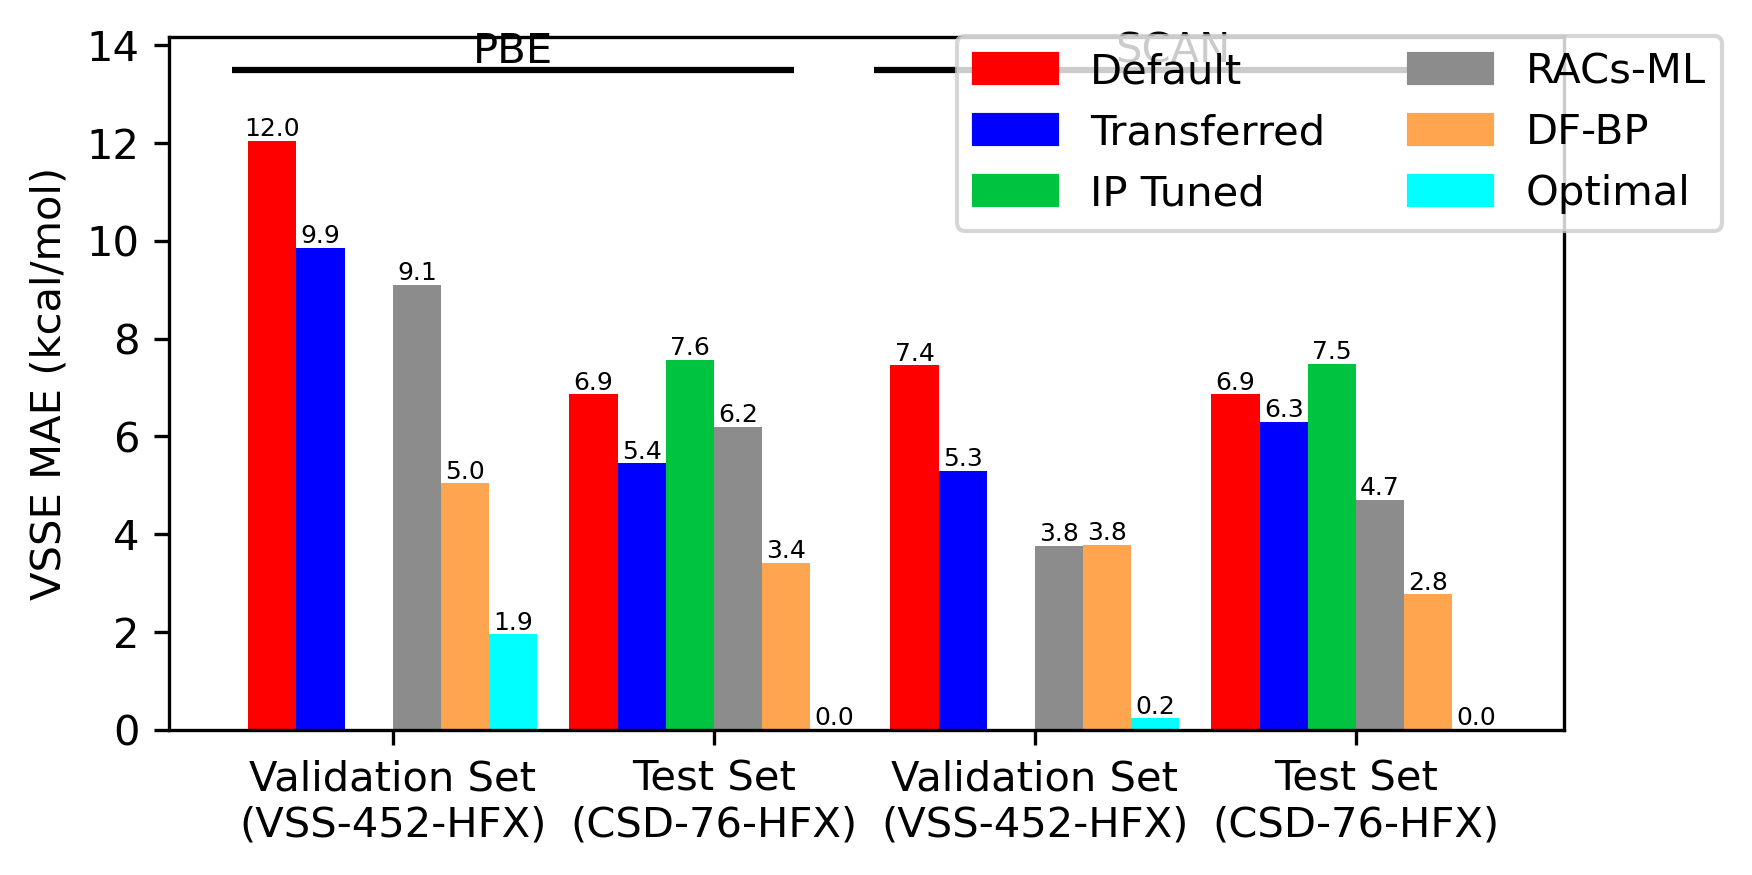

In [4]:
colors = ['#FF0000', '#0000FF', '#00C440', '#8c8c8c', '#FFA550', '#00FFFF']
sizes = np.arange(4)


fig, ax = plt.subplots(figsize=(6, 3), dpi=300)
ax.bar(sizes-0.375, mean_default, 0.15, color=colors[0])
ax.bar_label(ax.containers[0], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=6)
ax.bar(sizes-0.225, mean_transferred, 0.15, color=colors[1])
ax.bar_label(ax.containers[1], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=6)
ax.bar(sizes-0.075, mean_tuned, 0.15, color=colors[2])
ax.bar_label(ax.containers[2], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=6)
ax.bar(sizes+0.075, mean_racs, 0.15, color=colors[3])
ax.bar_label(ax.containers[3], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=6)
ax.bar(sizes+0.225, mean_df_bp, 0.15, color=colors[4])
ax.bar_label(ax.containers[4], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=6)
ax.bar(sizes+0.375, mean_optimal, 0.15, color=colors[5])
ax.bar_label(ax.containers[5], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=6)
ax.set_xticks(np.arange(4), ['Validation Set\n(VSS-452-HFX)', 'Test Set\n(CSD-76-HFX)', 'Validation Set\n(VSS-452-HFX)', 'Test Set\n(CSD-76-HFX)'])
ax.set_ylabel('VSSE MAE (kcal/mol)')


import matplotlib.patches as mpatches
patch0 = mpatches.Patch(color='#FF0000', label='Default')
patch1 = mpatches.Patch(color='#0000FF', label='Transferred')
patch2 = mpatches.Patch(color='#00C440', label='IP Tuned')
patch3 = mpatches.Patch(color='#8c8c8c', label='RACs-ML')
patch4 = mpatches.Patch(color='#FFA550', label='DF-BP')
patch5 = mpatches.Patch(color='#00FFFF', label='Optimal')
ax.legend(handles=[patch0, patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(0.55, 0.69), ncol=2)

ax.text(0.25, 13.65, 'PBE')
ax.text(2.25, 13.65, 'SCAN')
ax.hlines(13.5, xmin=-0.5, xmax=1.25, color='black')
ax.hlines(13.5, xmin=1.5, xmax=3.25, color='black')

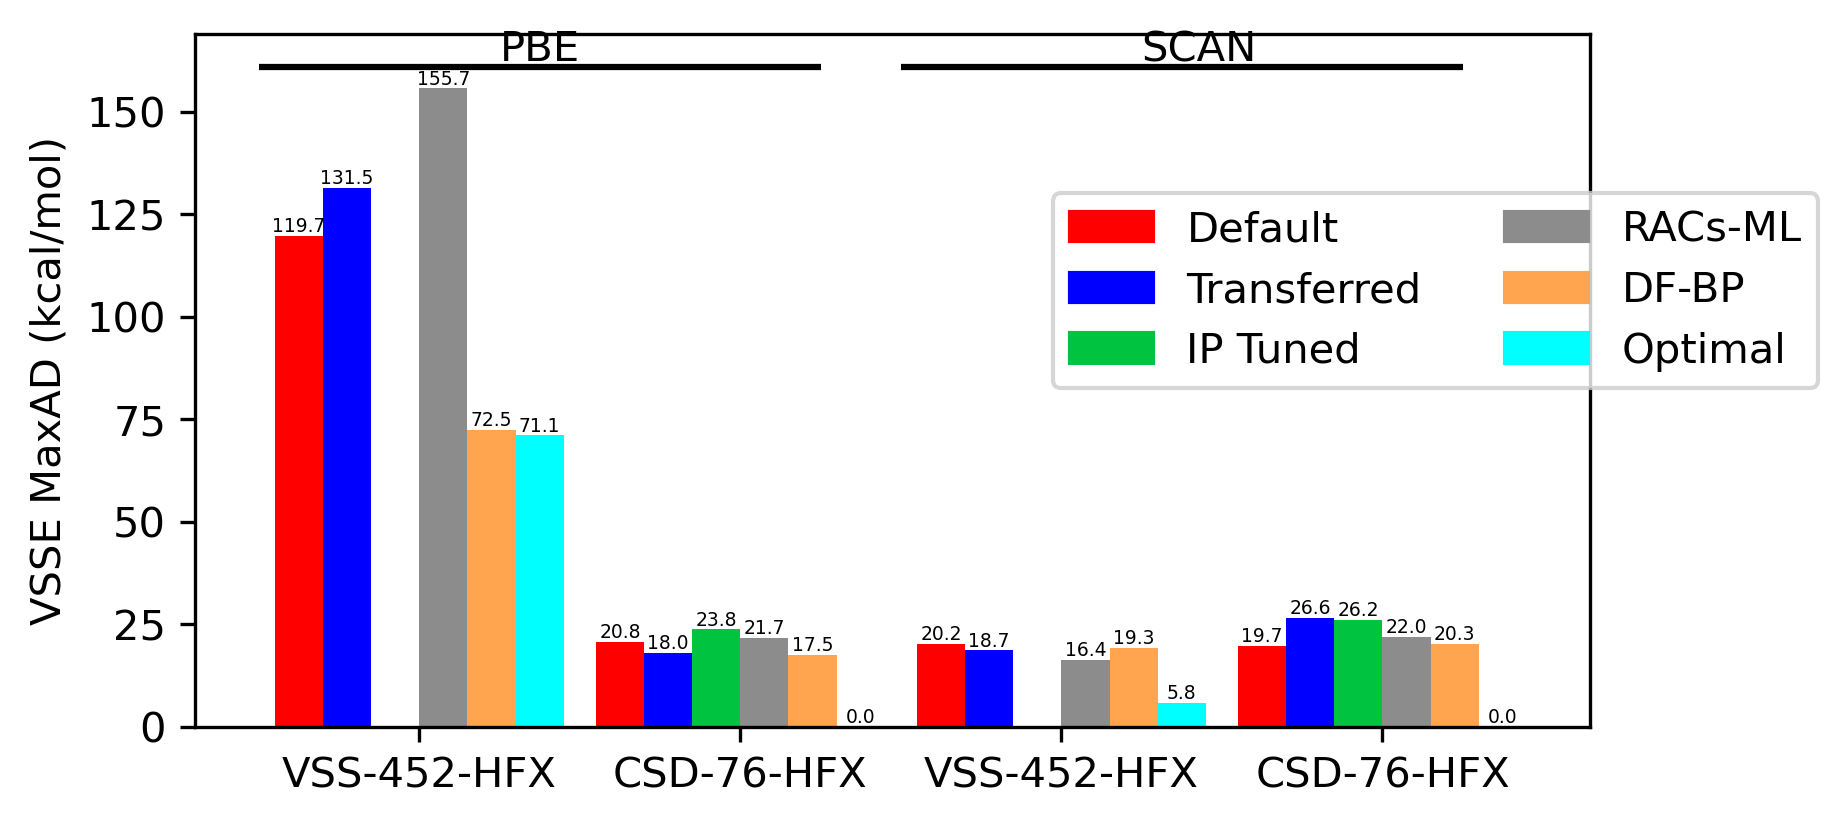

In [5]:
#SI figure for maximum error

colors = ['#FF0000', '#0000FF', '#00C440', '#8c8c8c', '#FFA550', '#00FFFF']
sizes = np.arange(4)


fig, ax = plt.subplots(figsize=(6, 3), dpi=300)

ax.bar(sizes-0.375, max_default, 0.15, color=colors[0])
ax.bar_label(ax.containers[0], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=4.5)
ax.bar(sizes-0.225, max_transferred, 0.15, color=colors[1])
ax.bar_label(ax.containers[1], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=4.5)
ax.bar(sizes-0.075, max_tuned, 0.15, color=colors[2])
ax.bar_label(ax.containers[2], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=4.5)
ax.bar(sizes+0.075, max_racs, 0.15, color=colors[3])
ax.bar_label(ax.containers[3], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=4.5)
ax.bar(sizes+0.225, max_df_bp, 0.15, color=colors[4])
ax.bar_label(ax.containers[4], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=4.5)
ax.bar(sizes+0.375, max_optimal, 0.15, color=colors[5])
ax.bar_label(ax.containers[5], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=4.5)
ax.set_xticks(np.arange(4), ['VSS-452-HFX', 'CSD-76-HFX', 'VSS-452-HFX', 'CSD-76-HFX'])
ax.set_ylabel('VSSE MaxAD (kcal/mol)')


import matplotlib.patches as mpatches
patch0 = mpatches.Patch(color='#FF0000', label='Default')
patch1 = mpatches.Patch(color='#0000FF', label='Transferred')
patch2 = mpatches.Patch(color='#00C440', label='IP Tuned')
patch3 = mpatches.Patch(color='#8c8c8c', label='RACs-ML')
patch4 = mpatches.Patch(color='#FFA550', label='DF-BP')
patch5 = mpatches.Patch(color='#00FFFF', label='Optimal')
ax.legend(handles=[patch0, patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(0.6, 0.8), ncol=2)

ax.text(0.25, 162.5, 'PBE')
ax.text(2.25, 162.5, 'SCAN')
ax.hlines(161, xmin=-0.5, xmax=1.25, color='black')
ax.hlines(161, xmin=1.5, xmax=3.25, color='black')